In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-03_17-00_20180601_20191231_th60_per24_sm5.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

NQ       0.25
YM       0.25
ES       0.25
GC       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    28647.50
GC    11100.52
NQ    26457.80
YM    41994.00
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

108199.82

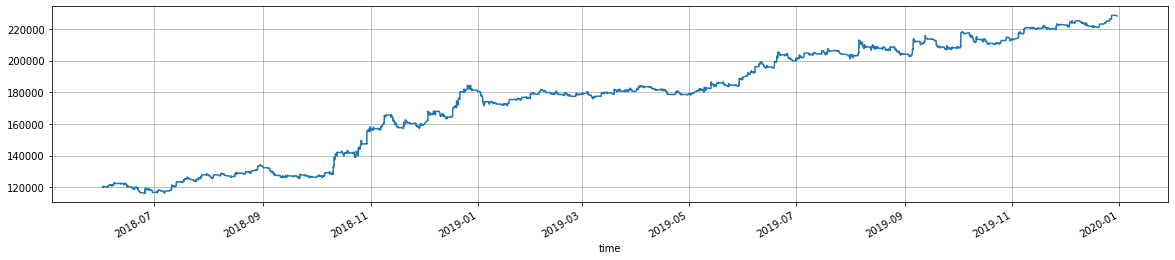

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     650
 GC    1195
 NQ    2132
 YM     660
 Name: action, dtype: int64,
 4637)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.577670
 GC    2.900485
 NQ    5.174757
 YM    1.601942
 Name: action, dtype: float64,
 11.254854368932039)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1365.0
GC    2891.9
NQ    4477.2
YM    1386.0
Name: commission, dtype: float64

In [15]:
df.commission.sum()

10120.1

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,18.59,450.63,-256.02,1.76,19.57,597.0
NQ,0.39,24.82,445.97,-250.07,1.78,21.39,1066.0
YM,0.43,127.25,755.94,-353.50,2.14,123.56,330.0
ES,0.41,88.15,906.06,-485.68,1.87,84.93,325.0
total,0.40,46.68,561.09,-297.99,1.88,45.64,2318.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.012997,0.235341,0.466299,0.726429
GC,0.012997,1.000000,0.054943,0.094553,0.373883
NQ,0.235341,0.054943,1.000000,0.240398,0.640042
YM,0.466299,0.094553,0.240398,1.000000,0.737980
total,0.726429,0.373883,0.640042,0.737980,1.000000


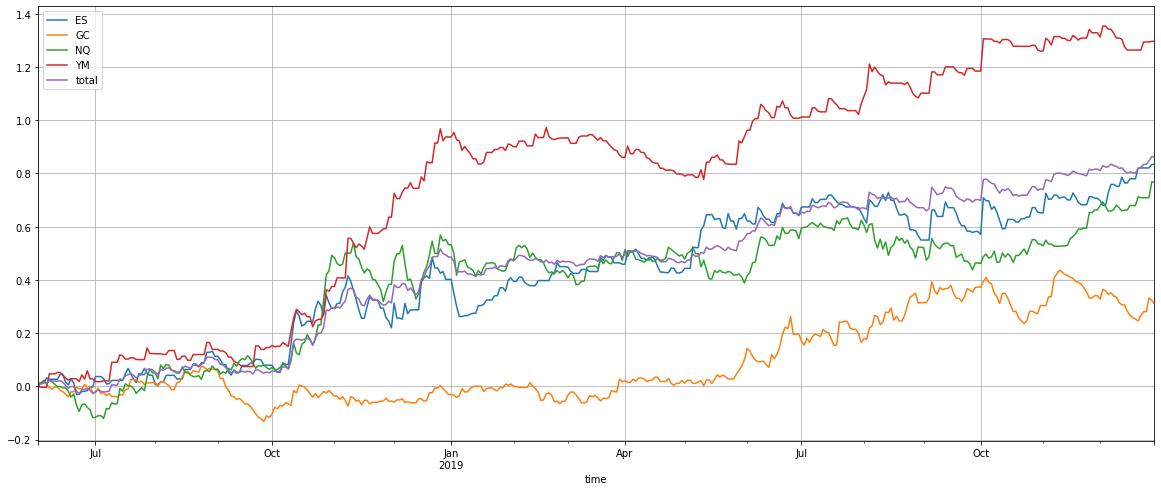

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

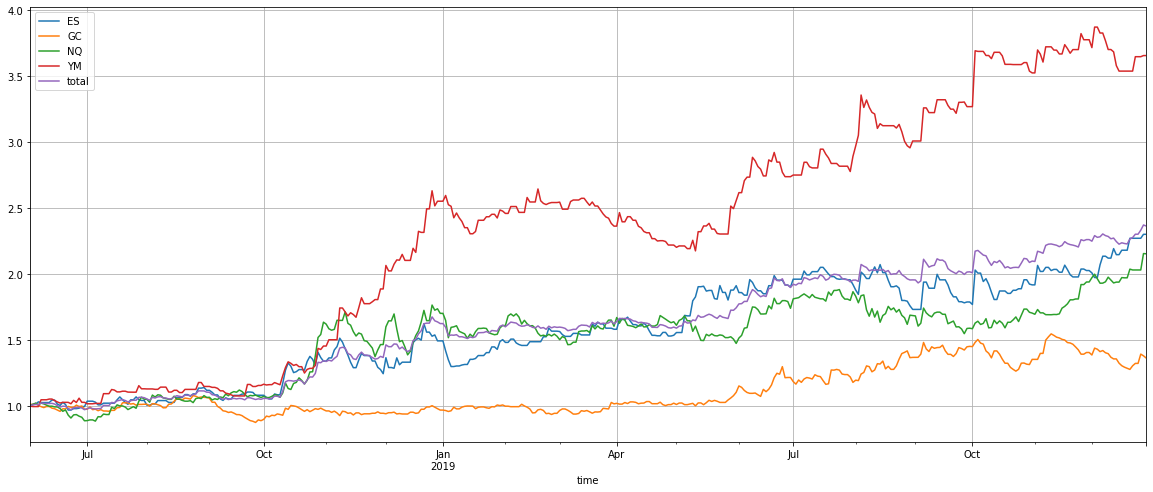

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.665383,0.209335,0.599223,1.210290,0.693133
Cumulative returns,1.302278,0.364449,1.154642,2.657188,1.365331
Annual volatility,0.389615,0.270833,0.375175,0.359129,0.223474
Sharpe ratio,1.499110,0.835648,1.437813,2.384070,2.467871
Calmar ratio,3.332098,1.110659,3.027577,6.823723,7.093572
Stability,0.916898,0.700090,0.734283,0.895568,0.947372
Max drawdown,-0.199689,-0.188478,-0.197922,-0.177365,-0.097713
Omega ratio,1.382445,1.163179,1.295453,1.786287,1.646053
Sortino ratio,2.995859,1.426948,2.410655,6.070059,5.614846
Skew,1.800874,0.974471,0.607139,2.587139,2.188987


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,-0.32,-2.36,-11.12,2.87,-2.71
2018-07-31,4.60,3.89,18.42,9.97,9.34
2018-08-31,7.41,5.03,1.24,1.56,3.96
2018-09-30,-3.33,-16.49,-0.01,0.67,-4.90
2018-10-31,23.87,9.41,53.58,25.82,27.87
2018-11-30,-7.11,-2.82,-10.37,29.73,1.78
2018-12-31,19.97,2.55,16.12,35.23,18.78
2019-01-31,0.63,4.00,-5.38,-2.93,-0.74
2019-02-28,4.28,-6.28,-5.05,2.62,-1.04


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       130.0
GC        36.0
NQ       115.0
YM       266.0
total    137.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 20:07:30,YM,SELL,26194.00,4805.8
2019-10-02 20:32:30,ES,BUY,2885.25,4420.8
2019-10-02 20:45:00,YM,BUY,26061.00,3885.8
2019-09-05 18:35:30,ES,SELL,2975.75,3583.3
2018-10-11 04:24:00,ES,BUY,2767.00,3395.8
...,...,...,...,...
2018-12-27 20:52:00,YM,BUY,22481.00,-1139.2
2018-12-10 13:49:00,ES,BUY,2636.25,-1204.2
2019-01-03 19:17:00,ES,SELL,2456.00,-1429.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-09-05,0.119443,0.063344,0.070387,0.083387,0.084140
2019-10-02,0.147360,0.022021,0.026633,0.129527,0.081385
2018-12-03,0.097360,-0.003989,0.091913,0.094360,0.069911
2018-10-29,0.076110,-0.005495,0.101773,0.098360,0.067687
2019-08-05,0.091387,0.041849,0.030293,0.100053,0.065896
...,...,...,...,...,...
2019-09-18,-0.020140,-0.018656,-0.042393,-0.013140,-0.023582
2019-06-26,-0.018890,-0.064473,0.000000,-0.012140,-0.023876
2018-12-10,-0.038197,0.003172,-0.061173,-0.000780,-0.024244
